In [ ]:
RED = "\033[91m"
GREEN = "\033[92m"
YELLOW = "\033[93m"
PURPLE = "\033[94m"
PINK = "\033[95m"
RESET = "\033[0m"

In [ ]:
from torch.nn import TransformerEncoder, TransformerEncoderLayer, TransformerDecoder, TransformerDecoderLayer
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.nn import Transformer
import torch.nn.functional as F
from transformers import BertTokenizer
from torch import Tensor
from torch import nn
from tqdm import tqdm
import warnings
import random
import torch
import math
import yaml
import json
import os
# warnings.filterwarnings("ignore")

# make tokenizer.yaml

In [ ]:
import yaml

# char_2_index mapping
tokenizer = {
    'char_2_index': {
        '[pad]': 0,
        '[sos]': 1,
        '[eos]': 2,
        'a': 3,
        'b': 4,
        'c': 5,
        'd': 6,
        'e': 7,
        'f': 8,
        'g': 9,
        'h': 10,
        'i': 11,
        'j': 12,
        'k': 13,
        'l': 14,
        'm': 15,
        'n': 16,
        'o': 17,
        'p': 18,
        'q': 19,
        'r': 20,
        's': 21,
        't': 22,
        'u': 23,
        'v': 24,
        'w': 25,
        'x': 26,
        'y': 27,
        'z': 28
    },
    'index_2_char': {
        0: '[pad]',
        1: '[sos]',
        2: '[eos]',
        3: 'a',
        4: 'b',
        5: 'c',
        6: 'd',
        7: 'e',
        8: 'f',
        9: 'g',
        10: 'h',
        11: 'i',
        12: 'j',
        13: 'k',
        14: 'l',
        15: 'm',
        16: 'n',
        17: 'o',
        18: 'p',
        19: 'q',
        20: 'r',
        21: 's',
        22: 't',
        23: 'u',
        24: 'v',
        25: 'w',
        26: 'x',
        27: 'y',
        28: 'z'
    }
}

#tokenizer['index_2_char'] = {v: k for k, v in tokenizer['char_2_index'].items()}
# Write the tokenizer dictionary to a YAML file
with open('data/tokenizer.yaml', 'w') as f:
    yaml.dump(tokenizer, f, default_flow_style=False)


# index2char()

In [ ]:
# class index2char():
#     def __init__(self, root, tokenizer=None):
#         if tokenizer is None:
#             with open(root + '/tokenizer.yaml', 'r') as f:
#                 self.tokenizer = yaml.load(f, Loader=yaml.CLoader)
#         else:
#             self.tokenizer = tokenizer

#     def __call__(self, indices:list, without_token=True):
#         if type(indices) == Tensor:
#             indices = indices.tolist()
#         result = ''.join([self.tokenizer['index_2_char'][i] for i in indices])
#         print(f"result:{result}")
#         if without_token:
#             result = result.split('[eos]')[0]
#             result = result.replace('[sos]', '').replace('[eos]', '').replace('[pad]', '')
#         return result



In [ ]:
class index2char:
    def __init__(self, root, tokenizer=None):
        if tokenizer is None:
            with open(root + '/tokenizer.yaml', 'r') as f:
                self.tokenizer = yaml.load(f, Loader=yaml.CLoader)
        else:
            self.tokenizer = tokenizer

    def __call__(self, indices: list, without_token=True):
        if isinstance(indices, Tensor):
            indices = indices.tolist()

        # Use `.get(i, '')` to provide a default value for missing keys
        result = ''.join([self.tokenizer['index_2_char'].get(i, '') for i in indices])

        if without_token:
            result = result.split('[eos]')[0]
            result = result.replace('[sos]', '').replace('[eos]', '').replace('[pad]', '')
        return result


In [ ]:
i2c = index2char('./data')
print(i2c([1, 2, 3, 4], without_token=False))

[sos][eos]ab


# 測 accuracy

In [ ]:
def metrics(pred:list, target:list) -> float:
    """
    pred: list of strings
    target: list of strings

    return: accuracy(%)
    """

    if len(pred) != len(target):
        raise ValueError('length of pred and target must be the same')
    correct = 0
    for i in range(len(pred)):
        if pred[i] == target[i]:
            correct += 1
    return correct / len(pred) * 100

# 參數setup

In [ ]:
embedding_num = 31
embedding_dim =  768
num_layers =  12
num_heads =  12
ff_dim = 1024
dropout = 0.1

## function

# SpellCorrectionDataset()

In [1]:
import json
import torch
from torch.utils.data import Dataset

class SpellCorrectionDataset(Dataset):
    def __init__(self, root='data', split: str = 'train', tokenizer=None, padding: int = 0):
        super(SpellCorrectionDataset, self).__init__()

        # Load the data from the corresponding .json file
        file_path = f"{root}/{split}.json"
        with open(file_path, 'r') as f:
            pre_data = json.load(f)

        if tokenizer is None:
            with open(root + '/tokenizer.yaml', 'r') as f:
                self.tokenizer = yaml.load(f, Loader=yaml.CLoader)
        else:
            self.tokenizer = tokenizer

        self.data=[]
        for i in range(len(pre_data)):
          for j in pre_data[i]['input']:
            self.data.append({'input':j ,'target':pre_data[i]['target']})

        self.padding = padding

    def tokenize(self, text: str):
        # Tokenize the text, for example: "data" -> [4, 1, 20, 1]
        indices = [self.tokenizer['char_2_index'][char] for char in text.lower()]

        if self.padding > 0:
            indices = indices[:self.padding] + [0] * max(0, self.padding - len(indices))
        #print(f"{PURPLE}indices_after padding: {indices}{RESET}")
        return indices


    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
      # Get data by index
      entry = self.data[index]
      input_text = entry['input']  # Assuming the 'input' is a list of misspelled words
      target_text = entry['target']
      # Convert to torch tensors and duplicate targets for each input variation
      input_tensors = torch.tensor(self.tokenize(input_text), dtype=torch.long)
      target_tensors = torch.tensor(self.tokenize(target_text), dtype=torch.long)

      return input_tensors, target_tensors



# PositionalEncoding()

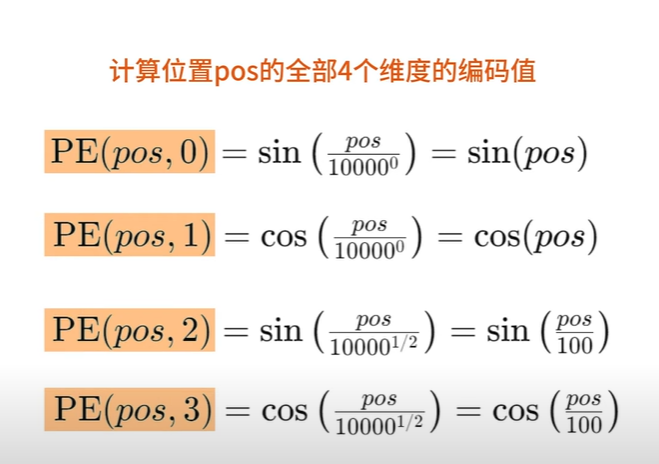

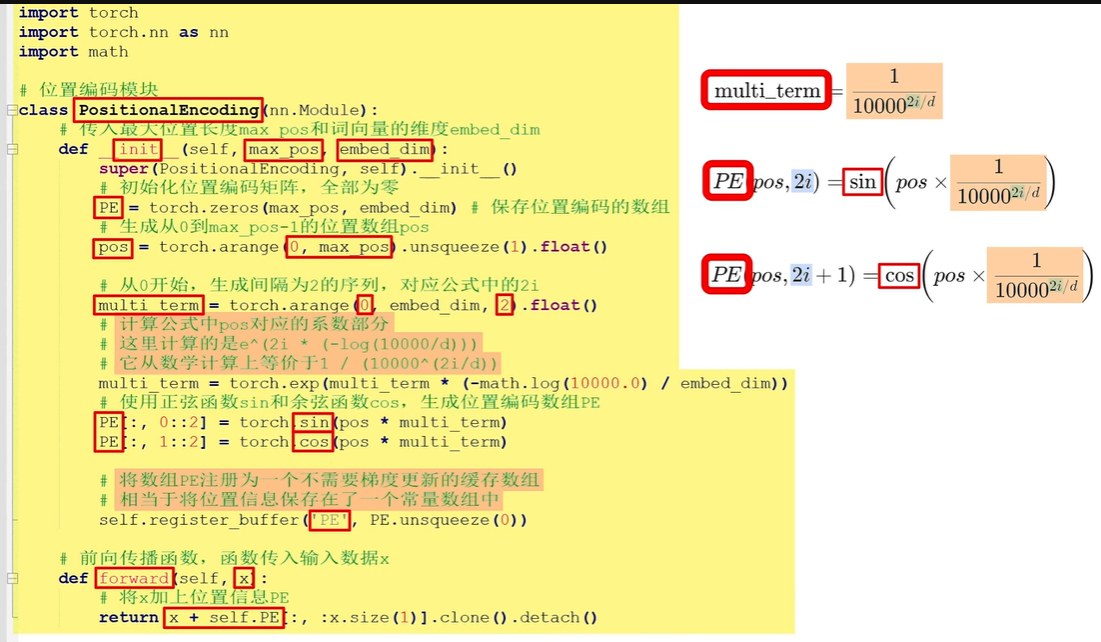

* [reference]:https://www.youtube.com/watch?v=7Pod6151eIk

In [ ]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000, batch_first: bool = False):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)
        self.batch_first = batch_first

    def forward(self, x: Tensor) -> Tensor:
        if self.batch_first:
            x = x.transpose(0, 1)
            x = x + self.pe[:x.size(0)]
            return self.dropout(x.transpose(0, 1))
        else:
            x = x + self.pe[:x.size(0)]
            return self.dropout(x)

# Encoder and Decoder

In [ ]:
class Encoder(nn.Module):
    def __init__(self, num_emb, hid_dim, n_layers, n_heads, ff_dim, dropout, max_length=100):
        super(Encoder, self).__init__()
        self.tok_embedding = nn.Embedding(num_emb, hid_dim)
        self.pos_embedding = PositionalEncoding(hid_dim, dropout, max_length, batch_first=True)
        self.layer = nn.TransformerEncoderLayer(d_model=hid_dim, nhead=n_heads, dim_feedforward=ff_dim, dropout=dropout)
        self.encoder = nn.TransformerEncoder(self.layer, num_layers=n_layers)

    def forward(self, src, src_mask=None, src_key_padding_mask=None):
        src = self.tok_embedding(src)  # Convert tokens to embeddings
        src = self.pos_embedding(src)  # Add positional encoding
        src = self.encoder(src, mask=src_mask, src_key_padding_mask=src_key_padding_mask)  # Pass through encoder layers
        #print(f"{RED}src: {src}{RESET}")
        return src

class Decoder(nn.Module):
    def __init__(self, num_emb, hid_dim, n_layers, n_heads, ff_dim, dropout, max_length=100):
        super(Decoder, self).__init__()
        self.tok_embedding = nn.Embedding(num_emb, hid_dim)
        self.pos_embedding = PositionalEncoding(hid_dim, dropout, max_length, batch_first=True)
        self.layer = nn.TransformerDecoderLayer(d_model=hid_dim, nhead=n_heads, dim_feedforward=ff_dim, dropout=dropout)
        self.decoder = nn.TransformerDecoder(self.layer, num_layers=n_layers)

    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None):
        tgt = self.tok_embedding(tgt)  # Convert tokens to embeddings
        tgt = self.pos_embedding(tgt)  # Add positional encoding
        tgt = self.decoder(tgt, memory, tgt_mask=tgt_mask, memory_mask=memory_mask,
                           tgt_key_padding_mask=tgt_key_padding_mask,
                           memory_key_padding_mask=memory_key_padding_mask)  # Pass through decoder layers
        #print(f"{GREEN}tgt: {tgt}{RESET}")
        return tgt

class TransformerAutoEncoder(nn.Module):
    def __init__(self, num_emb, hid_dim, n_layers, n_heads, ff_dim, dropout, max_length=100, encoder=None):
        super(TransformerAutoEncoder, self).__init__()
        if encoder is None:
            self.encoder = Encoder(num_emb, hid_dim, n_layers, n_heads, ff_dim, dropout, max_length)
        else:
            self.encoder = encoder
        self.decoder = Decoder(num_emb, hid_dim, n_layers, n_heads, ff_dim, dropout, max_length)
        self.output_layer = nn.Linear(hid_dim, num_emb)

    def forward(self, src, tgt, src_pad_mask=None, tgt_mask=None, tgt_pad_mask=None):
        enc_src = self.encoder(src, src_key_padding_mask=src_pad_mask)  # Encode the source sequence
        out = self.decoder(tgt, enc_src, tgt_mask=tgt_mask, memory_key_padding_mask=src_pad_mask,
                           tgt_key_padding_mask=tgt_pad_mask)  # Decode using encoded source
        out = self.output_layer(out)  # Apply output layer
        out = F.softmax(out, dim=-1)  # Apply softmax to get probabilities
        return out


# Mask function

In [ ]:
def gen_padding_mask(src, pad_idx):
    # detect where the padding value is
    pad_mask = (src == pad_idx).transpose(0, 1)
    return pad_mask


def gen_mask(seq):
    # triu mask for decoder
    size = seq.size(0)
    mask = torch.triu(torch.ones(size, size), diagonal=1).bool()
    return mask


def get_index(pred, dim=2):
    return pred.clone().argmax(dim=dim)


def random_change_idx(data: torch.Tensor, prob: float = 0.2):
    # randomly change the index of the input data
    mask = torch.rand(data.size()) < prob
    random_indices = torch.randint(0, data.size(-1), data.size(), dtype=torch.long)
    sample = data.clone()
    sample[mask] = random_indices[mask]
    return sample


def random_masked(data: torch.Tensor, prob: float = 0.2, mask_idx: int = 3):
    # randomly mask the input data
    mask = torch.rand(data.size()) < prob
    sample = data.clone()
    sample[mask] = mask_idx
    return sample

# Pretrained encoder with random mask

In [ ]:
# You can try to pretrain the Encoder here!
# Pretrain the Encoder
class PretrainedMaskedEncoder(Encoder):
    def __init__(self, num_emb, hid_dim, n_layers, n_heads, ff_dim, dropout, max_length=100, pretrained=True):
        super(PretrainedMaskedEncoder, self).__init__(num_emb, hid_dim, n_layers, n_heads, ff_dim, dropout, max_length)
        self.pretrained = pretrained

    def forward(self, src, src_mask=None, src_key_padding_mask=None):
        # Apply random masking before passing through the encoder
        if self.pretrained:
            src = random_masked(src, prob=0.2, mask_idx=0)  # Apply random masking to input data
        return super().forward(src, src_mask, src_key_padding_mask)

# # Example usage
# trainset = SpellCorrectionDataset('./data', padding=22, tokenizer=tokenizer)
# trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# encoder = Encoder(num_emb=len(tokenizer['char_2_index']) + 1, hid_dim=128, n_layers=3, n_heads=4, ff_dim=256, dropout=0.1).to(device)
# optimizer = torch.optim.Adam(encoder.parameters(), lr=0.001)
# criterion = nn.CrossEntropyLoss(ignore_index=0)

# pretrain_encoder(encoder, trainloader, optimizer, criterion, device)

# Create an instance of PretrainedMaskedEncoder

encoder = PretrainedMaskedEncoder(embedding_num, embedding_dim, num_layers, num_heads, ff_dim, dropout,  pretrained=True)

# Define some dummy input (batch_size=4, sequence_length=10)
src = torch.randint(0, embedding_num, (4, 10))

# Forward pass through the encoder
output = encoder(src)

print(output.shape)

torch.Size([4, 10, 768])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [ ]:
from torch.utils.data import DataLoader
import torch
from tqdm import tqdm
i2c = index2char('./data')

trainset = SpellCorrectionDataset('./data', padding=22)
trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
testset = SpellCorrectionDataset('./data', split='new_test', padding=22)
testloader = DataLoader(testset, batch_size=32, shuffle=False)
valset = SpellCorrectionDataset('./data', split='test', padding=22)
valloader = DataLoader(valset, batch_size=32, shuffle=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

ce_loss = nn.CrossEntropyLoss(ignore_index=0)


# test dataset

In [ ]:
# #testing
# i = 0
# done = 0
# print(f"{YELLOW}TRAIN_DATASET:{RESET}\n")

# for batch in trainloader:
#     input_tensor, target_tensor = batch

#     print(f"{RED}No.{i}:input_tensors: {input_tensor}{RESET}\n")
#     print(f"{GREEN}No.{i}:target_tensor: {target_tensor}{RESET}\n")
#     i += 1
#     if i == 5:
#       break

# i = 0
# done = 0
# print(f"{YELLOW}VAL_DATASET:{RESET}\n")
# for batch in valloader:
#     input_tensor, target_tensor = batch

#     print(f"{RED}No.{i}:input_tensors: {input_tensor}{RESET}\n")
#     print(f"{GREEN}No.{i}:target_tensor: {target_tensor}{RESET}\n")
#     i += 1
#     if i == 5:
#       break

# i = 0
# done = 0
# print(f"{YELLOW}TEST_DATASET:{RESET}\n")
# for batch in testloader:
#     input_tensor, target_tensor = batch

#     print(f"{RED}No.{i}:input_tensors: {input_tensor}{RESET}\n")
#     print(f"{GREEN}No.{i}:target_tensor: {target_tensor}{RESET}\n")
#     i += 1
#     if i == 5:
#       break

# Train our spelling correction transformer

In [ ]:
# Validation function
def validation(dataloader, model, device, logout=False):
    pred_str_list = []
    tgt_str_list = []
    input_str_list = []
    losses = []
    for src, tgt in dataloader:
        src, tgt = src.to(device), tgt.to(device)
        tgt_input = torch.zeros_like(tgt).fill_(0).to(device) # An all pad token tensor with the same shape as tgt
        tgt_input[:, 0] = 1  # Assuming <sos> token index is 1

        for i in range(tgt.shape[1] - 1):
            src_pad_mask = gen_padding_mask(src, pad_idx=0)
            tgt_pad_mask = gen_padding_mask(tgt_input, pad_idx=0)
            tgt_mask = gen_mask(tgt_input).to(device)

            pred = model(src, tgt_input, src_pad_mask, tgt_mask, tgt_pad_mask)
            # print(f"{YELLOW}pred: {pred}{RESET}")
            # print(f"{YELLOW}pred.shape: {pred.shape}{RESET}")

            pred_idx = get_index(pred)
            #print(f"{RED}pred_idx: {pred_idx}{RESET}")
            #print(f"{GREEN}tgt_input: {tgt_input}{RESET}")
            #print(f"{RED}pred_idx[:, i]: {pred_idx[:, i]}{RESET}")

            tgt_input[:, i + 1] = pred_idx[:, i]
            #print(f"{PURPLE}tgt_input: {tgt_input}{RESET}")

        for i in range(tgt.shape[0]):
            pred_str_list.append(i2c(tgt_input[i].tolist()))
            tgt_str_list.append(i2c(tgt[i].tolist()))
            input_str_list.append(i2c(src[i].tolist()))
            if logout:
                print('=' * 30)
                print(f'input: {input_str_list[-1]}')
                print(f'pred: {pred_str_list[-1]}')
                print(f'target: {tgt_str_list[-1]}')

        loss = ce_loss(pred[:, :-1, :].permute(0, 2, 1), tgt[:, 1:])
        losses.append(loss.item())

    print(f"test_acc: {metrics(pred_str_list, tgt_str_list):.2f}", f"test_loss: {sum(losses) / len(losses):.2f}", end=' | ')
    print(f"[pred: {pred_str_list[0]} target: {tgt_str_list[0]}]")


In [ ]:
# encoder.pretrained_mode = False
model = TransformerAutoEncoder(embedding_num, embedding_dim, num_layers, num_heads, ff_dim, dropout).to(device)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, betas=(0.9, 0.98), eps=1e-9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.95)

# from google.colab import drive
# drive.mount('/content/drive')
# # Load checkpoint if available
# checkpoint_path = '/content/drive/MyDrive/Colab Notebooks/陳建志-深度學習/Lab_5/checkpoint.pth'
# if os.path.exists(checkpoint_path):
#     checkpoint = torch.load(checkpoint_path)
#     model.load_state_dict(checkpoint['model_state_dict'])
#     optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#     start_epoch = checkpoint['epoch'] + 1
#     print(f"Resuming training from epoch {start_epoch}")
# else:
#     start_epoch = 0
start_epoch = 0
def save_checkpoint(epoch,checkpoint_path):
  # Save checkpoint
  torch.save({
        'epoch': eps,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': sum(losses) / len(losses),
        }, checkpoint_path)
  print(f"Checkpoint saved at epoch {eps}")

# Training loop with checkpointing
num_epochs = 1000
for eps in range(start_epoch , num_epochs):
    # train
    losses = []
    model.train()
    i_bar = tqdm(trainloader, unit='iter', desc=f'epoch{eps}')
    for src, tgt in i_bar:
        src, tgt = src.to(device), tgt.to(device) # src.shape = [32,22]

        # generate the mask and padding mask
        src_pad_mask = gen_padding_mask(src, pad_idx=0)  # Generate the padding mask
        tgt_pad_mask = gen_padding_mask(tgt, pad_idx=0)  # Generate the padding mask
        tgt_mask = gen_mask(tgt).to(device)  # Generate the mask

        optimizer.zero_grad()
        pred = model(src, tgt, src_pad_mask, tgt_mask, tgt_pad_mask) # pred.shape = [32,22,31]

        loss = ce_loss(pred[:, :-1, :].permute(0, 2, 1), tgt[:, 1:])
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        i_bar.set_postfix_str(f"loss: {sum(losses)/len(losses):.3f}")



    # test
    model.eval()
    with torch.no_grad():
        validation(testloader, model, device)
    model.eval()
    with torch.no_grad():
        validation(valloader, model, device)

epoch0: 100%|██████████| 404/404 [00:34<00:00, 11.85iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeeeeeeeeeeee target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeeeeee target: contented]


epoch1: 100%|██████████| 404/404 [00:33<00:00, 12.11iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeeeeeeeeeeee target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeeeeee target: contented]


epoch2: 100%|██████████| 404/404 [00:33<00:00, 12.08iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeeeeeeeeeeee target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeeeeee target: contented]


epoch3: 100%|██████████| 404/404 [00:33<00:00, 11.98iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeeeeeeeeeeee target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeeeeee target: contented]


epoch4: 100%|██████████| 404/404 [00:33<00:00, 12.07iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeeeeeeeeeeee target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeeeeee target: contented]


epoch5: 100%|██████████| 404/404 [00:33<00:00, 12.08iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeeeeeeeeeeee target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeeeeee target: contented]


epoch6: 100%|██████████| 404/404 [00:33<00:00, 12.03iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeeeeeeeeeeee target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeeeeee target: contented]


epoch7: 100%|██████████| 404/404 [00:33<00:00, 12.04iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeeeeeeeeeeee target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeeeeee target: contented]


epoch8: 100%|██████████| 404/404 [00:33<00:00, 12.04iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeeeeeeeeeeee target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeeeeee target: contented]


epoch9: 100%|██████████| 404/404 [00:33<00:00, 12.07iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeeeeeeeeeeee target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeeeeee target: contented]


epoch10: 100%|██████████| 404/404 [00:33<00:00, 12.05iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeeeeeeeeeeee target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeeeeee target: contented]


epoch11: 100%|██████████| 404/404 [00:33<00:00, 12.09iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeeeeeeeeeeee target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeeeeee target: contented]


epoch12: 100%|██████████| 404/404 [00:33<00:00, 12.04iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeeeeeeeeeeee target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeeeeee target: contented]


epoch13: 100%|██████████| 404/404 [00:33<00:00, 12.06iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeeeeeeeeeeee target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeeeeee target: contented]


epoch14: 100%|██████████| 404/404 [00:33<00:00, 12.06iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeeeeeeeeeeee target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeeeeee target: contented]


epoch15: 100%|██████████| 404/404 [00:33<00:00, 12.14iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeeeeeeeeeeee target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeeeeee target: contented]


epoch16: 100%|██████████| 404/404 [00:33<00:00, 12.05iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeeeeeeeeeeee target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeeeeee target: contented]


epoch17: 100%|██████████| 404/404 [00:33<00:00, 12.00iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeeeeeeeeeeee target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeeeeee target: contented]


epoch18: 100%|██████████| 404/404 [00:33<00:00, 12.10iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeeeeeeeeeeee target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeeeeee target: contented]


epoch19: 100%|██████████| 404/404 [00:33<00:00, 12.08iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeeeeeeeeeeee target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeeeeee target: contented]


epoch20: 100%|██████████| 404/404 [00:33<00:00, 12.10iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeeeeeeeeeeee target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeeeeee target: contented]


epoch21: 100%|██████████| 404/404 [00:33<00:00, 12.09iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeesssssssssss target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeesssss target: contented]


epoch22: 100%|██████████| 404/404 [00:33<00:00, 12.10iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeesssssssssss target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeesssss target: contented]


epoch23: 100%|██████████| 404/404 [00:33<00:00, 12.02iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeesssssssssss target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeesssss target: contented]


epoch24: 100%|██████████| 404/404 [00:33<00:00, 12.08iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeesssssssssss target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeesssss target: contented]


epoch25: 100%|██████████| 404/404 [00:33<00:00, 12.10iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeesssssssssss target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeesssss target: contented]


epoch26: 100%|██████████| 404/404 [00:33<00:00, 12.04iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeesssssssssss target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeesssss target: contented]


epoch27: 100%|██████████| 404/404 [00:33<00:00, 12.07iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeesssssssssss target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeesssss target: contented]


epoch28: 100%|██████████| 404/404 [00:33<00:00, 12.06iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeesssssssssss target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeesssss target: contented]


epoch29: 100%|██████████| 404/404 [00:33<00:00, 12.11iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeesssssssssss target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeesssss target: contented]


epoch30: 100%|██████████| 404/404 [00:33<00:00, 12.02iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeesssssssssss target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeesssss target: contented]


epoch31: 100%|██████████| 404/404 [00:33<00:00, 12.08iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeesssssssssss target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeesssss target: contented]


epoch32: 100%|██████████| 404/404 [00:33<00:00, 12.07iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeesssssssssss target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeesssss target: contented]


epoch33: 100%|██████████| 404/404 [00:33<00:00, 12.08iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeesssssssssss target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeesssss target: contented]


epoch34: 100%|██████████| 404/404 [00:33<00:00, 12.06iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeesssssssssss target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeesssss target: contented]


epoch35: 100%|██████████| 404/404 [00:33<00:00, 12.09iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeesssssssssss target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeesssss target: contented]


epoch36: 100%|██████████| 404/404 [00:33<00:00, 12.09iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeesssssssssss target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeesssss target: contented]


epoch37: 100%|██████████| 404/404 [00:33<00:00, 12.06iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch38: 100%|██████████| 404/404 [00:33<00:00, 12.09iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch39: 100%|██████████| 404/404 [00:33<00:00, 12.08iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch40: 100%|██████████| 404/404 [00:33<00:00, 12.03iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch41: 100%|██████████| 404/404 [00:33<00:00, 12.08iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch42: 100%|██████████| 404/404 [00:33<00:00, 12.05iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch43: 100%|██████████| 404/404 [00:33<00:00, 12.05iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch44: 100%|██████████| 404/404 [00:33<00:00, 12.10iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch45: 100%|██████████| 404/404 [00:33<00:00, 12.12iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch46: 100%|██████████| 404/404 [00:33<00:00, 12.03iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch47: 100%|██████████| 404/404 [00:33<00:00, 12.06iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch48: 100%|██████████| 404/404 [00:33<00:00, 12.12iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch49: 100%|██████████| 404/404 [00:33<00:00, 12.09iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch50: 100%|██████████| 404/404 [00:33<00:00, 12.01iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch51: 100%|██████████| 404/404 [00:33<00:00, 12.03iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch52: 100%|██████████| 404/404 [00:33<00:00, 12.04iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch53: 100%|██████████| 404/404 [00:33<00:00, 12.07iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch54: 100%|██████████| 404/404 [00:33<00:00, 12.00iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch55: 100%|██████████| 404/404 [00:33<00:00, 12.10iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch56: 100%|██████████| 404/404 [00:33<00:00, 12.09iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch57: 100%|██████████| 404/404 [00:33<00:00, 12.07iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch58: 100%|██████████| 404/404 [00:33<00:00, 12.03iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch59: 100%|██████████| 404/404 [00:33<00:00, 11.99iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch60: 100%|██████████| 404/404 [00:33<00:00, 12.04iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch61: 100%|██████████| 404/404 [00:33<00:00, 11.95iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch62: 100%|██████████| 404/404 [00:33<00:00, 12.10iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch63: 100%|██████████| 404/404 [00:33<00:00, 12.04iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch64: 100%|██████████| 404/404 [00:33<00:00, 12.03iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch65: 100%|██████████| 404/404 [00:33<00:00, 12.12iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch66: 100%|██████████| 404/404 [00:33<00:00, 12.10iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch67: 100%|██████████| 404/404 [00:33<00:00, 12.16iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch68: 100%|██████████| 404/404 [00:33<00:00, 12.03iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch69: 100%|██████████| 404/404 [00:33<00:00, 12.07iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch70: 100%|██████████| 404/404 [00:33<00:00, 12.04iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch71: 100%|██████████| 404/404 [00:33<00:00, 12.03iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch72: 100%|██████████| 404/404 [00:33<00:00, 12.07iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch73: 100%|██████████| 404/404 [00:33<00:00, 12.06iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch74: 100%|██████████| 404/404 [00:33<00:00, 12.09iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch75: 100%|██████████| 404/404 [00:33<00:00, 12.04iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch76: 100%|██████████| 404/404 [00:33<00:00, 12.08iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch77: 100%|██████████| 404/404 [00:33<00:00, 12.09iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch78: 100%|██████████| 404/404 [00:33<00:00, 12.01iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch79: 100%|██████████| 404/404 [00:33<00:00, 12.09iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch80: 100%|██████████| 404/404 [00:33<00:00, 12.10iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch81: 100%|██████████| 404/404 [00:33<00:00, 12.06iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch82: 100%|██████████| 404/404 [00:33<00:00, 12.01iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch83: 100%|██████████| 404/404 [00:33<00:00, 12.07iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch84: 100%|██████████| 404/404 [00:33<00:00, 12.07iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch85: 100%|██████████| 404/404 [00:33<00:00, 12.02iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch86: 100%|██████████| 404/404 [00:33<00:00, 12.03iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch87: 100%|██████████| 404/404 [00:33<00:00, 12.02iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch88: 100%|██████████| 404/404 [00:33<00:00, 12.06iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch89: 100%|██████████| 404/404 [00:33<00:00, 12.05iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch90: 100%|██████████| 404/404 [00:33<00:00, 12.10iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch91: 100%|██████████| 404/404 [00:33<00:00, 12.13iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch92: 100%|██████████| 404/404 [00:33<00:00, 11.97iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch93: 100%|██████████| 404/404 [00:33<00:00, 12.04iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch94: 100%|██████████| 404/404 [00:33<00:00, 12.10iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch95: 100%|██████████| 404/404 [00:33<00:00, 12.04iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch96: 100%|██████████| 404/404 [00:33<00:00, 12.03iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch97: 100%|██████████| 404/404 [00:33<00:00, 12.05iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch98: 100%|██████████| 404/404 [00:33<00:00, 12.08iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch99: 100%|██████████| 404/404 [00:33<00:00, 12.02iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch100: 100%|██████████| 404/404 [00:33<00:00, 12.10iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch101: 100%|██████████| 404/404 [00:33<00:00, 12.07iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch102: 100%|██████████| 404/404 [00:33<00:00, 12.07iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch103: 100%|██████████| 404/404 [00:33<00:00, 12.12iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch104: 100%|██████████| 404/404 [00:33<00:00, 12.08iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch105: 100%|██████████| 404/404 [00:33<00:00, 12.03iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch106: 100%|██████████| 404/404 [00:33<00:00, 12.08iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch107: 100%|██████████| 404/404 [00:33<00:00, 12.10iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch108: 100%|██████████| 404/404 [00:33<00:00, 12.08iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch109: 100%|██████████| 404/404 [00:33<00:00, 11.95iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch110: 100%|██████████| 404/404 [00:33<00:00, 12.05iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch111: 100%|██████████| 404/404 [00:33<00:00, 12.01iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch112: 100%|██████████| 404/404 [00:33<00:00, 12.06iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch113: 100%|██████████| 404/404 [00:33<00:00, 12.07iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch114: 100%|██████████| 404/404 [00:33<00:00, 12.12iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch115: 100%|██████████| 404/404 [00:33<00:00, 12.03iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch116: 100%|██████████| 404/404 [00:33<00:00, 11.99iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch117: 100%|██████████| 404/404 [00:33<00:00, 12.05iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch118: 100%|██████████| 404/404 [00:33<00:00, 12.06iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch119: 100%|██████████| 404/404 [00:33<00:00, 12.01iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch120: 100%|██████████| 404/404 [00:33<00:00, 12.06iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch121: 100%|██████████| 404/404 [00:33<00:00, 12.05iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch122: 100%|██████████| 404/404 [00:33<00:00, 11.99iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch123: 100%|██████████| 404/404 [00:33<00:00, 11.97iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch124: 100%|██████████| 404/404 [00:33<00:00, 12.08iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch125: 100%|██████████| 404/404 [00:33<00:00, 12.08iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch126: 100%|██████████| 404/404 [00:33<00:00, 12.05iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch127: 100%|██████████| 404/404 [00:33<00:00, 12.07iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch128: 100%|██████████| 404/404 [00:33<00:00, 12.03iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch129: 100%|██████████| 404/404 [00:33<00:00, 12.05iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch130: 100%|██████████| 404/404 [00:33<00:00, 12.09iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch131: 100%|██████████| 404/404 [00:33<00:00, 12.08iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch132: 100%|██████████| 404/404 [00:33<00:00, 12.02iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch133: 100%|██████████| 404/404 [00:33<00:00, 12.01iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch134: 100%|██████████| 404/404 [00:33<00:00, 12.09iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch135: 100%|██████████| 404/404 [00:33<00:00, 12.07iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch136: 100%|██████████| 404/404 [00:33<00:00, 12.08iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch137: 100%|██████████| 404/404 [00:33<00:00, 12.08iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch138: 100%|██████████| 404/404 [00:33<00:00, 12.05iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch139: 100%|██████████| 404/404 [00:33<00:00, 12.05iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch140: 100%|██████████| 404/404 [00:33<00:00, 12.04iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch141: 100%|██████████| 404/404 [00:33<00:00, 12.00iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch142: 100%|██████████| 404/404 [00:33<00:00, 12.03iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch143: 100%|██████████| 404/404 [00:33<00:00, 12.03iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch144: 100%|██████████| 404/404 [00:33<00:00, 12.03iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch145: 100%|██████████| 404/404 [00:33<00:00, 12.07iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch146: 100%|██████████| 404/404 [00:33<00:00, 12.02iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch147: 100%|██████████| 404/404 [00:33<00:00, 12.10iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch148: 100%|██████████| 404/404 [00:33<00:00, 12.08iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch149: 100%|██████████| 404/404 [00:33<00:00, 12.05iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch150: 100%|██████████| 404/404 [00:33<00:00, 12.03iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch151: 100%|██████████| 404/404 [00:33<00:00, 12.06iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch152: 100%|██████████| 404/404 [00:33<00:00, 12.05iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch153: 100%|██████████| 404/404 [00:33<00:00, 11.98iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch154: 100%|██████████| 404/404 [00:33<00:00, 12.04iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch155: 100%|██████████| 404/404 [00:33<00:00, 12.02iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch156: 100%|██████████| 404/404 [00:33<00:00, 12.07iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch157: 100%|██████████| 404/404 [00:33<00:00, 11.98iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch158: 100%|██████████| 404/404 [00:33<00:00, 12.03iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch159: 100%|██████████| 404/404 [00:33<00:00, 12.11iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch160: 100%|██████████| 404/404 [00:33<00:00, 12.02iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch161: 100%|██████████| 404/404 [00:33<00:00, 11.99iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch162: 100%|██████████| 404/404 [00:33<00:00, 12.05iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch163: 100%|██████████| 404/404 [00:33<00:00, 12.05iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch164: 100%|██████████| 404/404 [00:33<00:00, 12.03iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch165: 100%|██████████| 404/404 [00:33<00:00, 12.04iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch166: 100%|██████████| 404/404 [00:33<00:00, 12.05iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch167: 100%|██████████| 404/404 [00:33<00:00, 11.98iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch168: 100%|██████████| 404/404 [00:33<00:00, 12.05iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch169: 100%|██████████| 404/404 [00:33<00:00, 12.06iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch170: 100%|██████████| 404/404 [00:33<00:00, 11.96iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch171: 100%|██████████| 404/404 [00:33<00:00, 12.05iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch172: 100%|██████████| 404/404 [00:33<00:00, 12.06iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch173: 100%|██████████| 404/404 [00:33<00:00, 12.08iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch174: 100%|██████████| 404/404 [00:33<00:00, 11.99iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch175: 100%|██████████| 404/404 [00:33<00:00, 12.02iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch176: 100%|██████████| 404/404 [00:33<00:00, 12.07iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch177: 100%|██████████| 404/404 [00:33<00:00, 11.96iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch178: 100%|██████████| 404/404 [00:33<00:00, 12.04iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch179: 100%|██████████| 404/404 [00:33<00:00, 12.03iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch180: 100%|██████████| 404/404 [00:33<00:00, 12.00iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch181: 100%|██████████| 404/404 [00:33<00:00, 11.97iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch182: 100%|██████████| 404/404 [00:33<00:00, 12.02iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch183: 100%|██████████| 404/404 [00:33<00:00, 11.98iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch184: 100%|██████████| 404/404 [00:33<00:00, 12.00iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch185: 100%|██████████| 404/404 [00:33<00:00, 12.07iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch186: 100%|██████████| 404/404 [00:33<00:00, 12.05iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch187: 100%|██████████| 404/404 [00:33<00:00, 12.00iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch188: 100%|██████████| 404/404 [00:33<00:00, 12.00iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch189: 100%|██████████| 404/404 [00:33<00:00, 12.00iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch190: 100%|██████████| 404/404 [00:33<00:00, 12.05iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch191: 100%|██████████| 404/404 [00:33<00:00, 11.97iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch192: 100%|██████████| 404/404 [00:33<00:00, 12.03iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch193: 100%|██████████| 404/404 [00:33<00:00, 12.01iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch194: 100%|██████████| 404/404 [00:33<00:00, 11.94iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch195: 100%|██████████| 404/404 [00:33<00:00, 12.08iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch196: 100%|██████████| 404/404 [00:33<00:00, 12.03iter/s, loss: 3.347]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch197: 100%|██████████| 404/404 [00:33<00:00, 12.09iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeeeeeeeeeeee target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeeeeee target: contented]


epoch198: 100%|██████████| 404/404 [00:33<00:00, 12.02iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch199: 100%|██████████| 404/404 [00:33<00:00, 12.03iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch200: 100%|██████████| 404/404 [00:33<00:00, 12.04iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch201: 100%|██████████| 404/404 [00:33<00:00, 11.96iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch202: 100%|██████████| 404/404 [00:33<00:00, 12.04iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch203: 100%|██████████| 404/404 [00:33<00:00, 12.03iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch204: 100%|██████████| 404/404 [00:33<00:00, 12.01iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch205: 100%|██████████| 404/404 [00:33<00:00, 12.01iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.30 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch206: 100%|██████████| 404/404 [00:33<00:00, 12.05iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch207: 100%|██████████| 404/404 [00:33<00:00, 12.06iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch208: 100%|██████████| 404/404 [00:33<00:00, 11.99iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch209: 100%|██████████| 404/404 [00:33<00:00, 12.08iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch210: 100%|██████████| 404/404 [00:33<00:00, 12.07iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.35 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.35 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch211: 100%|██████████| 404/404 [00:33<00:00, 12.01iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch212: 100%|██████████| 404/404 [00:33<00:00, 12.05iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch213: 100%|██████████| 404/404 [00:33<00:00, 12.04iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch214: 100%|██████████| 404/404 [00:33<00:00, 12.08iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch215: 100%|██████████| 404/404 [00:33<00:00, 12.00iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch216: 100%|██████████| 404/404 [00:33<00:00, 12.03iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch217: 100%|██████████| 404/404 [00:33<00:00, 12.01iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch218: 100%|██████████| 404/404 [00:33<00:00, 12.01iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch219: 100%|██████████| 404/404 [00:33<00:00, 12.10iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch220: 100%|██████████| 404/404 [00:33<00:00, 12.11iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch221: 100%|██████████| 404/404 [00:33<00:00, 12.13iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch222: 100%|██████████| 404/404 [00:33<00:00, 12.09iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch223: 100%|██████████| 404/404 [00:33<00:00, 12.18iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch224: 100%|██████████| 404/404 [00:33<00:00, 12.17iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch225: 100%|██████████| 404/404 [00:33<00:00, 12.13iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch226: 100%|██████████| 404/404 [00:33<00:00, 12.19iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch227: 100%|██████████| 404/404 [00:33<00:00, 12.12iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch228: 100%|██████████| 404/404 [00:33<00:00, 12.19iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch229: 100%|██████████| 404/404 [00:33<00:00, 12.14iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch230: 100%|██████████| 404/404 [00:33<00:00, 12.20iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch231: 100%|██████████| 404/404 [00:33<00:00, 12.18iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch232: 100%|██████████| 404/404 [00:33<00:00, 12.16iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch233: 100%|██████████| 404/404 [00:33<00:00, 12.20iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch234: 100%|██████████| 404/404 [00:33<00:00, 12.17iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch235: 100%|██████████| 404/404 [00:33<00:00, 12.18iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch236: 100%|██████████| 404/404 [00:33<00:00, 12.14iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch237: 100%|██████████| 404/404 [00:33<00:00, 12.20iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch238: 100%|██████████| 404/404 [00:33<00:00, 12.14iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch239: 100%|██████████| 404/404 [00:33<00:00, 12.13iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch240: 100%|██████████| 404/404 [00:33<00:00, 12.16iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch241: 100%|██████████| 404/404 [00:33<00:00, 12.12iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch242: 100%|██████████| 404/404 [00:33<00:00, 12.17iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch243: 100%|██████████| 404/404 [00:33<00:00, 12.10iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch244: 100%|██████████| 404/404 [00:33<00:00, 12.16iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch245: 100%|██████████| 404/404 [00:33<00:00, 12.15iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch246: 100%|██████████| 404/404 [00:33<00:00, 12.09iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch247: 100%|██████████| 404/404 [00:33<00:00, 12.18iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch248: 100%|██████████| 404/404 [00:33<00:00, 12.11iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch249: 100%|██████████| 404/404 [00:33<00:00, 12.13iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch250: 100%|██████████| 404/404 [00:33<00:00, 12.13iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch251: 100%|██████████| 404/404 [00:33<00:00, 12.22iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch252: 100%|██████████| 404/404 [00:33<00:00, 12.16iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch253: 100%|██████████| 404/404 [00:33<00:00, 12.14iter/s, loss: 3.348]


test_acc: 0.00 test_loss: 3.29 | [pred: eeeeeeeeeeyyyyyyyyyyy target: appreciate]
test_acc: 0.00 test_loss: 3.34 | [pred: eeeeeeeeeeeeeeeeyyyyy target: contented]


epoch254:  27%|██▋       | 110/404 [00:09<00:24, 12.24iter/s, loss: 3.351]

In [ ]:
#model = TransformerAutoEncoder(embedding_num, embedding_dim, num_layers, num_heads, ff_dim, dropout).to(device)
validation(testloader, model, device, logout=True)

In [ ]:
validation(valloader, model, device, logout=True)